# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.



<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/adriangb/scikeras/blob/master/notebooks/Basic_Usage.ipyn">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/adriangb/scikeras/blob/master/notebooks/Basic_Usage.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

### Table of contents

* [Data](#Data)
* [Define Model](#Define-Keras-Model)
* [Training](#Training)
* [Explore Results](#Explore-Results)

Install SciKeras

In [ ]:
!python -m pip install scikeras

Silence TensorFlow warnings to keep output succint.

In [22]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')

## Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [23]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [24]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """A regular SciKeras ``get_model``."""
    # This is our input image
    input_img = keras.Input(shape=(784,), name="input")
    # "encoded" is the encoded representation of the input
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    # This model maps an input to its reconstruction
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Extract the input layer and encoded output from ``fit_model``."""
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Create a new input layer and connect it to the fitted ``fit_model``."""
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [25]:
from sklearn.base import TransformerMixin, copy
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        # Fit the auto-encoder to predict X from X
        super().fit(X=X, y=X, sample_weight=sample_weight)
        # Copy encoder/decoder models to avoid modifying user input objects
        self.tf_est_ = copy.copy(self.tf_est)
        self.inv_tf_est_ = copy.copy(self.inv_tf_est)
        # Set params for encoder/decoder models
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        # Preprocess X
        X = self.feature_encoder_.transform(X)
        # Fit tf_est_
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        # Fit inverse TF
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [26]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=50)

## Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [27]:
autoencoder.fit(X=x_train)

Epoch 1/50
1875/1875 [==============================] - 2s 925us/step - loss: 0.2026
Epoch 2/50
1875/1875 [==============================] - 2s 867us/step - loss: 0.1060
Epoch 3/50
1875/1875 [==============================] - 2s 908us/step - loss: 0.0976
Epoch 4/50
1875/1875 [==============================] - 2s 851us/step - loss: 0.0960
Epoch 5/50
1875/1875 [==============================] - 2s 868us/step - loss: 0.0952
Epoch 6/50
1875/1875 [==============================] - 2s 873us/step - loss: 0.0948
Epoch 7/50
1875/1875 [==============================] - 2s 908us/step - loss: 0.0945
Epoch 8/50
1875/1875 [==============================] - 2s 958us/step - loss: 0.0947
Epoch 9/50
1875/1875 [==============================] - 2s 976us/step - loss: 0.0944
Epoch 10/50
1875/1875 [==============================] - 2s 973us/step - loss: 0.0942
Epoch 11/50
1875/1875 [==============================] - 2s 974us/step - loss: 0.0942
Epoch 12/50
1875/1875 [==============================] - 2s 1ms

KerasTransformer(
	model=<function get_fit_model at 0x14dcec790>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=binary_crossentropy
	metrics=None
	batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	encoding_dim=32
	tf_est__model=<function get_tf_model at 0x14dcec9d0>
	tf_est__build_fn=None
	tf_est__warm_start=False
	tf_est__random_state=None
	tf_est__optimizer=rmsprop
	tf_est__loss=None
	tf_est__metrics=None
	tf_est__batch_size=None
	tf_est__verbose=0
	tf_est__callbacks=None
	tf_est__validation_split=0.0
	tf_est__shuffle=True
	tf_est__run_eagerly=False
	tf_est__epochs=1
	tf_est__fit_model=None
	tf_est=BaseWrapper(
	model=<function get_tf_model at 0x14dcec9d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	fit_model=None
)
	inv_tf_est__model=<

Next we fit the encoder and decoder using training data and then round-trip through both using test data.

In [28]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## Explore Results

Now let's compare our inputs to lossy decoded outputs:

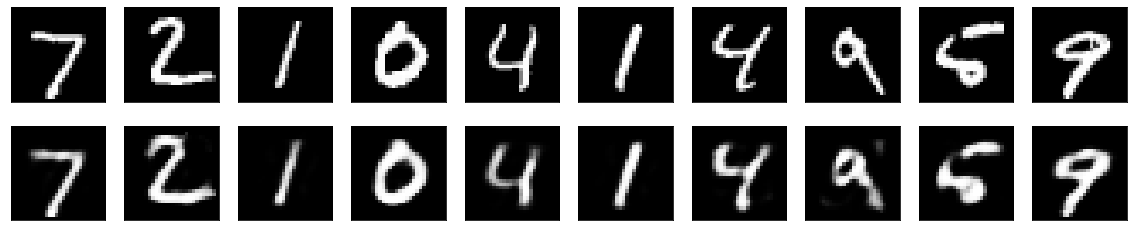

In [29]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [30]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
space_saving = (1-encoded_imgs.astype(x_test.dtype).nbytes/x_test.nbytes)*100
print(f"Space saving: {space_saving:0.2f}%")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Space saving: 95.92%
